In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from itertools import combinations, groupby
import seaborn as sns
from matplotlib.tri import Triangulation
from operator import itemgetter
from sklearn.metrics import auc
from funcs_plots import twosigma, loop_EWSs_store_results_pvalue
from funcs_plots import open_pvalue_files, power_metric
import sys
sys.path.append("..")
from funcs_all import statistics_on_window, realisation_detrending

# Stats

In [3]:
stats_of_interest = ['Variance', 'AC(1)', 'CV', 'Decay Time', 'Index of Dispersion', 'Mean']
stat_name = [x[:2] for x in stats_of_interest]

# Figure 5 - comparison of detection methods


In [5]:
Time =100
realisations = 500
Ext_res, Fix_res, FixChange_res = open_pvalue_files(Time)

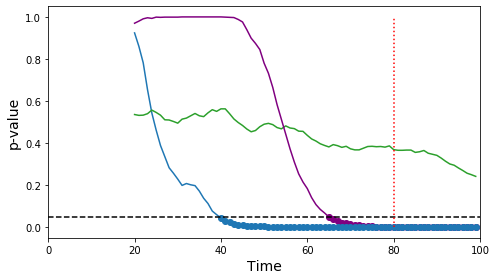

In [6]:
key = 'CV'
test =145
fix_stat_res = Fix_res[key]
ext_stat_res = Ext_res[key]
fixchange_stat_res = FixChange_res[key]

fig, ax = plt.subplots(1, figsize = (7,4))


ax.plot(ext_stat_res.loc[test,:],'-', c = 'tab:blue', label = 'Bifurcating Simulation')
ax.plot(fix_stat_res.loc[test,:],'-', c= 'tab:green', label = 'Steady State Simulation')
ax.plot(fixchange_stat_res.loc[test,:],'-', c= 'purple', label = 'NExt (decreasing \nnot bifurcating)')

ax.plot(fix_stat_res.loc[test,:][fix_stat_res.loc[test,:]<0.05].index,
        fix_stat_res.loc[test,:][fix_stat_res.loc[test,:]<0.05].values,
        'o', c= 'tab:green', label = 'NExt (decreasing \nnot bifurcating)')

ax.plot(fixchange_stat_res.loc[test,:][fixchange_stat_res.loc[test,:]<0.05].index,
        fixchange_stat_res.loc[test,:][fixchange_stat_res.loc[test,:]<0.05].values,
        'o', c= 'purple', label = 'NExt (decreasing \nnot bifurcating)')
ax.plot(ext_stat_res.loc[test,:][ext_stat_res.loc[test,:]<0.05].index,
        ext_stat_res.loc[test,:][ext_stat_res.loc[test,:]<0.05].values,
        'o', c= 'tab:blue', label = 'NExt (decreasing \nnot bifurcating)')


ax.plot([0, Time+Time//10], [0.05, 0.05], '--', c='k', label ='pvalue = 0.05')
ax.plot([Time*(4/5),Time*(4/5) ], [0, 1],':', c='r', label =r'$R_0=1$')
ax.set_xlim([0,100])
ax.set_xlabel('Time', fontsize = 14)
ax.set_ylabel('p-value', fontsize = 14)
fig.tight_layout()
fig.savefig('Figs/timeseries_change_pvalue.pdf')

# Open csv files
Produced by running `pvalue_consecutive.py`

In [ ]:
usr = "../data/"

In [8]:
def read_data_lengths(Time, result, type_data,
                      str_data = 'results/pvalues/', 
                      count = True):
    '''
    Function for opening results 
    
    INPUT
    :param Time, integer. Length of time-series (e.g. 20, 50, 100, 250)
    :param result, str. Either "start", "total" or "end"
    :param type_data, str. Either "Ext", "Fix", "FixChange"
    :param str_data, str. Location of the data (e.g. "../data/results/pvalues") 
    :param count, default True. If True then counts the number of detections ...
    ... if False then takes the mean detection time
    
    RETURNS
    dict containing the number of simulations which returned a detection for each ...
    ... consecutive constraint
    '''
    Results_TP = {}
    for length in range(1,(Time//2)+1):
        
        consec_results = pd.read_csv((usr+
                                    str_data+
                                    type_data.upper()+
                                      '_negVM_posIDCVACD_'+
                                     str(length) +
                                     't_'+str(Time)+'_'+
                                     str(result) +
                                     '.csv'),
                                   index_col=0)
        consec_results.rename(columns={'AC':'AC(1)'}, inplace=True)

        if count:
            Results_TP[str(length)] = consec_results[consec_results>0].count()
        else:
            Results_TP[str(length)] = consec_results[consec_results>0].mean()
    return Results_TP

In [9]:
FixResults_TP_100 = read_data_lengths(Time = 100, 
                                 result = 'total',
                                     type_data='Fix')
FixCHANGEResults_TP_100 = read_data_lengths(Time = 100, 
                                 result = 'total',
                                     type_data='FixChange')
ExtResults_TP_100 = read_data_lengths(Time = 100, 
                                 result = 'total', 
                                     type_data='Ext')

#### 20 ####
FixResults_TP_20 = read_data_lengths(Time = 20, 
                                 result = 'total',
                                     type_data='Fix')
FixCHANGEResults_TP_20 = read_data_lengths(Time = 20, 
                                 result = 'total',
                                     type_data='FixChange')
ExtResults_TP_20 = read_data_lengths(Time = 20, 
                                 result = 'total', 
                                     type_data='Ext')

#### 50 ####
FixResults_TP_50 = read_data_lengths(Time = 50, 
                                 result = 'total',
                                     type_data='Fix')
FixCHANGEResults_TP_50 = read_data_lengths(Time = 50, 
                                 result = 'total',
                                     type_data='FixChange')
ExtResults_TP_50 = read_data_lengths(Time = 50, 
                                 result = 'total', 
                                     type_data='Ext')

#### 250 ####
FixResults_TP_250 = read_data_lengths(Time = 250, 
                                 result = 'total',
                                     type_data='Fix')
FixCHANGEResults_TP_250 = read_data_lengths(Time = 250, 
                                 result = 'total',
                                     type_data='FixChange')
ExtResults_TP_250 = read_data_lengths(Time = 250, 
                                 result = 'total', 
                                     type_data='Ext')

# Find Sensitivity and Specificity for each time-series length 

In [10]:
true_negative_rate100 =( 500-pd.concat(FixResults_TP_100, axis =1))/500
true_negative_rate50 =( 500-pd.concat(FixResults_TP_50, axis =1))/500
true_negative_rate20 =( 500-pd.concat(FixResults_TP_20, axis =1))/500
true_negative_rate250 =( 500-pd.concat(FixResults_TP_250, axis =1))/500

In [11]:
true_negativeCHANGE_rate100 =( 500-pd.concat(FixCHANGEResults_TP_100, axis =1))/500
true_negativeCHANGE_rate50 =( 500-pd.concat(FixCHANGEResults_TP_50, axis =1))/500
true_negativeCHANGE_rate20 =( 500-pd.concat(FixCHANGEResults_TP_20, axis =1))/500
true_negativeCHANGE_rate250 =( 500-pd.concat(FixCHANGEResults_TP_250, axis =1))/500

In [12]:
true_positive_rate100 = pd.concat(ExtResults_TP_100, axis =1)/500
true_positive_rate50 = pd.concat(ExtResults_TP_50, axis =1)/500
true_positive_rate20 = pd.concat(ExtResults_TP_20, axis =1)/500
true_positive_rate250 = pd.concat(ExtResults_TP_250, axis =1)/500

## Power Metric
PM = TPR - FPR

In [13]:
#EXT vs FIX

normalised_rate100 = power_metric(pd.concat(ExtResults_TP_100, axis =1),
                                   pd.concat(FixResults_TP_100, axis =1))

normalised_rate250 = power_metric(pd.concat(ExtResults_TP_250, axis =1),
                                   pd.concat(FixResults_TP_250, axis =1))

normalised_rate50 = power_metric(pd.concat(ExtResults_TP_50, axis =1),
                                   pd.concat(FixResults_TP_50, axis =1))

normalised_rate20 = power_metric(pd.concat(ExtResults_TP_20, axis =1),
                                   pd.concat(FixResults_TP_20, axis =1))

In [14]:
#EXT vs NEXT

normalised_rateCHANGE100 = power_metric(pd.concat(ExtResults_TP_100, axis =1),
                                   pd.concat(FixCHANGEResults_TP_100, axis =1))

normalised_rateCHANGE250 = power_metric(pd.concat(ExtResults_TP_250, axis =1),
                                   pd.concat(FixCHANGEResults_TP_250, axis =1))

normalised_rateCHANGE50 = power_metric(pd.concat(ExtResults_TP_50, axis =1),
                                   pd.concat(FixCHANGEResults_TP_50, axis =1))

normalised_rateCHANGE20 = power_metric(pd.concat(ExtResults_TP_20, axis =1),
                                   pd.concat(FixCHANGEResults_TP_20, axis =1))

In [15]:
# EXT vs BOTH
# PM = 2*TPR - FPR1 - FPR2

normalised_100 = normalised_rate100 + normalised_rateCHANGE100
normalised_50 = normalised_rate50 + normalised_rateCHANGE50
normalised_250 = normalised_rate250 + normalised_rateCHANGE250
normalised_20 = normalised_rate20 + normalised_rateCHANGE20

# Figure 6 -  Power Metric Analysis

In [16]:
n = len(np.arange(-2,2.01, 0.1))

cmap = sns.color_palette("coolwarm", n)

In [17]:
sortby_order = normalised_100.max(axis=1).sort_values(ascending=False).index.values
print('best for both', sortby_order[0], 
      'value', normalised_100.max(axis=1).sort_values(ascending=False).iloc[0],
     'consecutive', normalised_100.loc[ sortby_order[0]].idxmax())


best for both CV value 0.858 consecutive 9


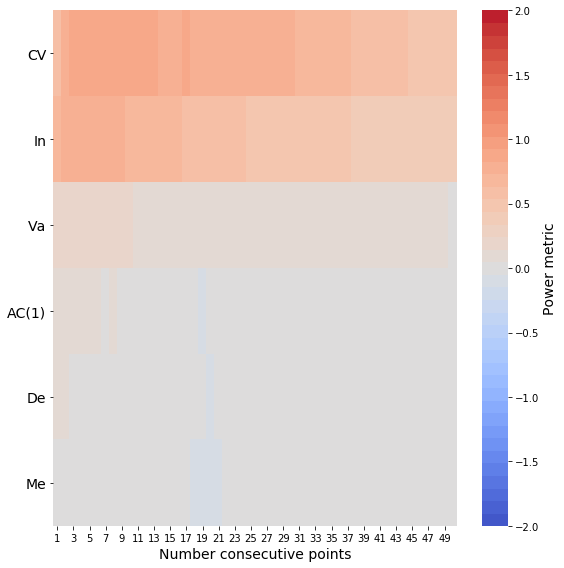

In [18]:

fig, ax = plt.subplots(1,1, figsize = (8, 8))

chart = sns.heatmap(normalised_100.loc[sortby_order], 
                    ax = ax,
           yticklabels=True, 
                   cmap = cmap, vmin =-2, vmax =2, cbar_kws={'label': 'Power metric'})
ax.figure.axes[-1].set_ylabel('Power metric', size=14)
ax.yaxis.set_tick_params(labelsize=14, rotation = 0)
ax.xaxis.set_tick_params(labelsize=10)

chart.set(xlabel='Number consecutive points')
ax.xaxis.get_label().set_fontsize(14)
fig.tight_layout()
fig.savefig('Figs/normalised_tpr_minus_fpr_pvalue100.pdf')


# Figure S1

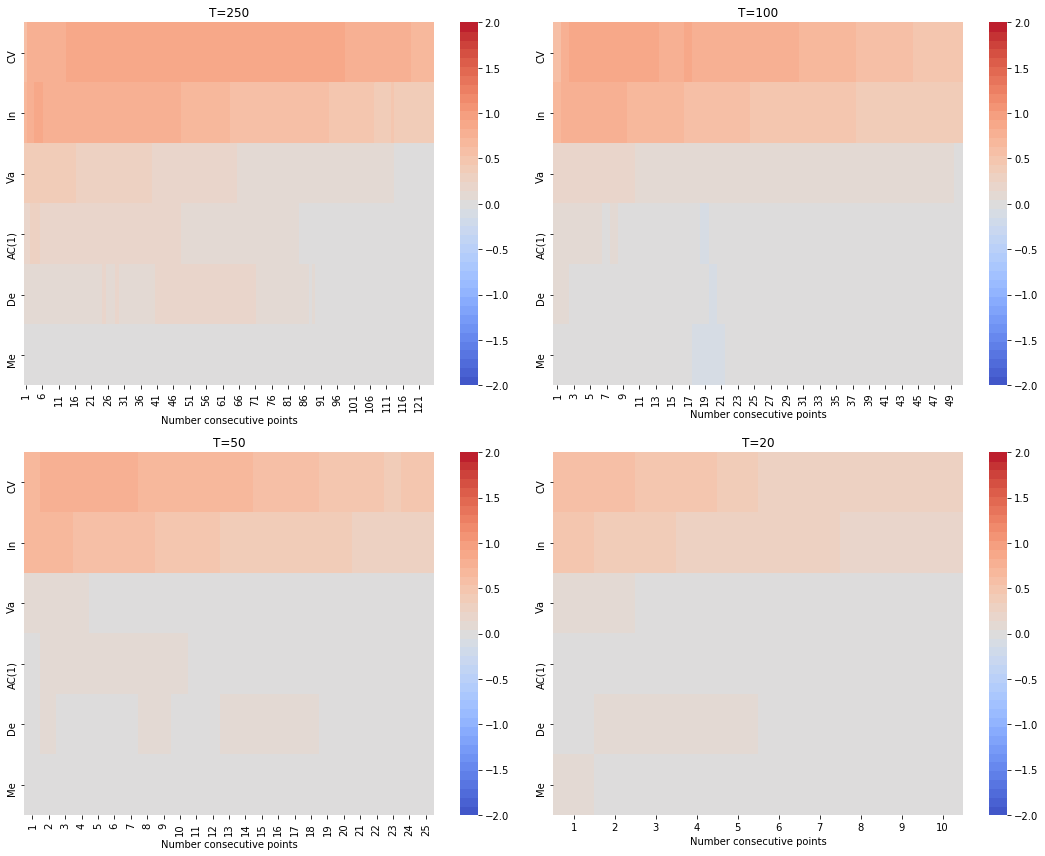

In [19]:
fig, ax = plt.subplots(2,2, figsize = (15, 12))
ax = ax.ravel()

chart = sns.heatmap(normalised_250.loc[sortby_order],
                    ax = ax[0],
           yticklabels=True, 
                   cmap = cmap, vmin =-2, vmax =2)
ax[0].set_title('T=250')
chart.set(xlabel='Number consecutive points')


chart = sns.heatmap(normalised_100.loc[sortby_order], 
                    ax = ax[1],
           yticklabels=True, 
                   cmap = cmap, vmin =-2, vmax =2)
ax[1].set_title('T=100')
chart.set(xlabel='Number consecutive points')


chart = sns.heatmap(normalised_50.loc[sortby_order], 
                    ax = ax[2],
           yticklabels=True, 
                   cmap = cmap, vmin =-2, vmax =2)
ax[2].set_title('T=50')
chart.set(xlabel='Number consecutive points')


chart = sns.heatmap(normalised_20.loc[sortby_order], ax = ax[3],
           yticklabels=True, 
                   cmap = cmap, vmin =-2, vmax =2)
chart.set(xlabel='Number consecutive points')

ax[3].set_title('T=20')
fig.tight_layout()
fig.savefig('Figs/normalised_tpr_minus_fpr_pvalue.pdf')

# Figure S2 - Power metric for time-series data up to the bifurcation point

In [20]:
def read_data_lengths_upto_80(Time, result, type_data,
                            str_data ='results/pvalues/', 
                              count = True):
    '''
    As in Function: read_data_lengths() but up to 80% of the time-series length
    '''
    Results_TP = {}
    for length in range(1,(Time//2)+1):
        
        consec_results = pd.read_csv((usr+
                                    str_data+
                                    type_data.upper()+
                                      '_negVM_posIDCVACD_'+
                                     str(length) +
                                     't_'+str(Time)+'_'+
                                     str(result) +
                                     '.csv'),
                                   index_col=0)
        consec_results.rename(columns={'AC':'AC(1)'}, inplace=True)
        consec_results = consec_results + length -1
        if count:
            Results_TP[str(length)] = consec_results[(consec_results>0) & (consec_results<=int(0.8*Time))].count()
        else:
            Results_TP[str(length)] = consec_results[(consec_results>0) & (consec_results<=int(0.8*Time))].mean()
    return Results_TP

In [21]:
FixResults_TP100_80= read_data_lengths_upto_80(Time = 100, 
                                 result = 'start',
                                     type_data='Fix')
ExtResults_TP100_80= read_data_lengths_upto_80(Time = 100, 
                                 result = 'start', 
                                     type_data='Ext')

FixCHANGEResults_TP100_80 = read_data_lengths_upto_80(Time = 100, 
                                 result = 'start',
                                     type_data='FixChange')


In [22]:
true_negative_rate100_80 =( 500-pd.concat(FixResults_TP100_80, axis =1))/500
true_negativeCHANGE_rate100_80 =( 500-pd.concat(FixCHANGEResults_TP100_80, axis =1))/500
true_positive_rate100_80 = pd.concat(ExtResults_TP100_80, axis =1)/500

normalised_rate100_80 = power_metric(pd.concat(ExtResults_TP100_80, axis =1),
                                   pd.concat(FixResults_TP100_80, axis =1))
normalised_rateCHANGE100_80 = power_metric(pd.concat(ExtResults_TP100_80, axis =1),
                                   pd.concat(FixCHANGEResults_TP100_80, axis =1))
normalised_100_80 = normalised_rate100_80 + normalised_rateCHANGE100_80

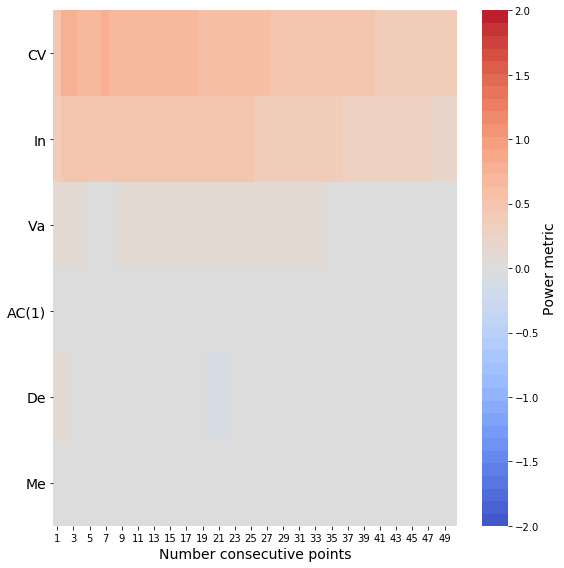

In [23]:

fig, ax = plt.subplots(1,1, figsize = (8, 8))

chart = sns.heatmap(normalised_100_80.loc[sortby_order], 
                    ax = ax,
           yticklabels=True, 
                   cmap = cmap, vmin =-2, vmax =2, cbar_kws={'label': 'Power metric'})
ax.figure.axes[-1].set_ylabel('Power metric', size=14)
ax.yaxis.set_tick_params(labelsize=14, rotation = 0)
ax.xaxis.set_tick_params(labelsize=10)

chart.set(xlabel='Number consecutive points')
ax.xaxis.get_label().set_fontsize(14)
fig.tight_layout()
fig.savefig('Figs/normalised_tpr_minus_fpr_pvalue100_upto80.pdf')


# ROC Curves

In [24]:
false_positive_rate_100 =(pd.concat(FixResults_TP_100, axis =1))/500
false_positive_rate_100 = false_positive_rate_100.loc[sortby_order]
true_positive_rate_100 = pd.concat(ExtResults_TP_100, axis =1)/500
true_positive_rate_100 = true_positive_rate_100.loc[sortby_order]

In [25]:
false_positive_rate_20 =(pd.concat(FixResults_TP_20, axis =1))/500
true_positive_rate_20 = pd.concat(ExtResults_TP_20, axis =1)/500
true_positive_rate_20 = true_positive_rate_20.loc[sortby_order]
false_positive_rate_20 = false_positive_rate_20.loc[sortby_order]

false_positive_rate_50 =(pd.concat(FixResults_TP_50, axis =1))/500
true_positive_rate_50 = pd.concat(ExtResults_TP_50, axis =1)/500
true_positive_rate_50 = true_positive_rate_50.loc[sortby_order]
false_positive_rate_50 = false_positive_rate_50.loc[sortby_order]

false_positive_rate_250 =(pd.concat(FixResults_TP_250, axis =1))/500
true_positive_rate_250 = pd.concat(ExtResults_TP_250, axis =1)/500
true_positive_rate_250 = true_positive_rate_250.loc[sortby_order]
false_positive_rate_250 = false_positive_rate_250.loc[sortby_order]

0
1
2
3


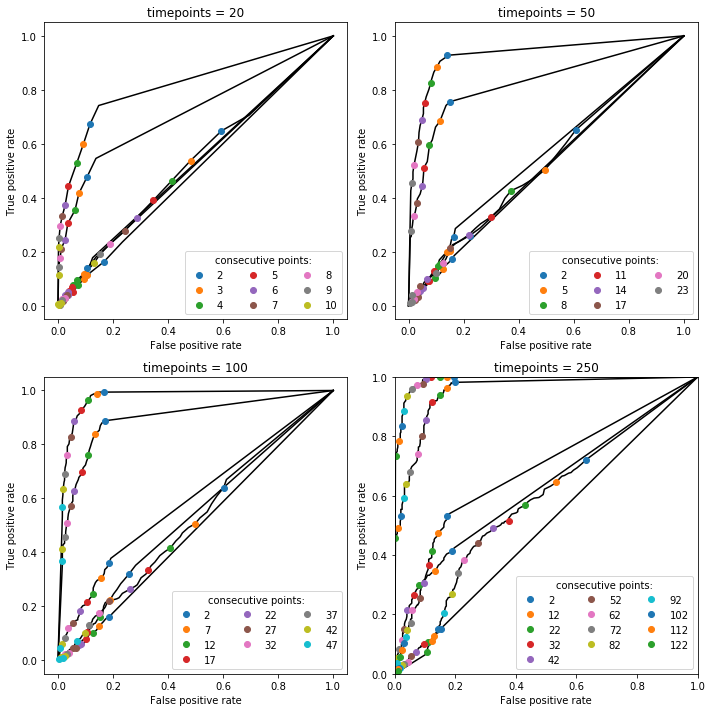

In [26]:
fig, ax = plt.subplots(2,2, figsize = (10, 10))
ax = ax.ravel()
axes = 0
for fpr, tpr in zip([ false_positive_rate_20,
                     false_positive_rate_50,false_positive_rate_100,false_positive_rate_250
                     ],
                       [ true_positive_rate_20,
                        true_positive_rate_50,true_positive_rate_100,true_positive_rate_250
                        ]):
    
    print(axes)
    for index in false_positive_rate_100.index:
    #add 0 and 1 into every
        fpr_data = fpr.loc[index].values
        fpr_data = np.append(np.append(1, fpr_data),0)
        tpr_data = tpr.loc[index].values
        tpr_data = np.append(np.append(1, tpr_data),0)
        monotonic = np.where(np.diff(tpr_data)<=0)[0]
        monotonic =np.append(monotonic, monotonic[-1]+1)

        ax[axes].plot(fpr_data[monotonic], tpr_data[monotonic], c='k')
    axes = axes+1


plt.ylim([0,1])
plt.xlim([0,1])
    

for col in false_positive_rate_100.columns[1::5]:
    
    ax[2].plot(false_positive_rate_100[col], true_positive_rate_100[col], 'o',
               label = col)
    ax[2].legend(title = 'consecutive points:',ncol =3, loc = 'lower right')
    ax[2].set_ylabel('True positive rate')
    ax[2].set_xlabel('False positive rate')
    ax[2].set_title('timepoints = 100')  
for col in false_positive_rate_20.columns[1:]:
    ax[0].plot(false_positive_rate_20[col], 
               true_positive_rate_20[col], 'o', label = col)
    ax[0].legend(title = 'consecutive points:',ncol =3, loc = 'lower right')
    ax[0].set_ylabel('True positive rate')
    ax[0].set_xlabel('False positive rate')
    ax[0].set_title('timepoints = 20')  
for col in false_positive_rate_50.columns[1::3]:
    ax[1].plot(false_positive_rate_50[col], 
               true_positive_rate_50[col], 'o', label = col)
    ax[1].legend(title = 'consecutive points:',ncol =3, loc = 'lower right')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_xlabel('False positive rate')
    ax[1].set_title('timepoints = 50')  
    
for col in false_positive_rate_250.columns[1::10]:
    ax[3].plot(false_positive_rate_250[col], 
               true_positive_rate_250[col], 'o', label = col)
    ax[3].legend(title = 'consecutive points:',ncol =3, loc = 'lower right')
    ax[3].set_ylabel('True positive rate')
    ax[3].set_xlabel('False positive rate')
    ax[3].set_title('timepoints = 250')  

fig.tight_layout()


# Calculate the AUC and the optimal threshold (consecutive point)

In [27]:
auc_results = np.zeros((4, len(false_positive_rate_100.index)))
threshold_results = np.zeros((4, len(false_positive_rate_100.index)))
axes = 0
for fpr, tpr in zip([false_positive_rate_20, false_positive_rate_50,
                     false_positive_rate_100, false_positive_rate_250
                    ],
                       [
                       true_positive_rate_20, true_positive_rate_50,
                           true_positive_rate_100, true_positive_rate_250
                        ]):
    
    for val, index in enumerate(false_positive_rate_100.index):
    #add 0 and 1 into every
        fpr_data = fpr.loc[index].values
        tpr_data = tpr.loc[index].values
                
        optimal_idx = np.argmax( tpr_data - fpr_data)
        optimal_threshold = fpr.columns.values[optimal_idx]
        threshold_results[axes,val] = optimal_threshold
        
        fpr_data = np.append(np.append(1, fpr_data),0)
        tpr_data = np.append(np.append(1, tpr_data),0)
        monotonic = np.where(np.diff(tpr_data)<=0)[0]
        monotonic =np.append(monotonic, monotonic[-1]+1)
        
        res = auc(fpr_data[monotonic], tpr_data[monotonic])
        auc_results[axes,val ] =res
    axes = axes +1

In [28]:
area_under_curve_df = pd.DataFrame(data = auc_results, columns=false_positive_rate_100.index,
             index = [  '20T', '50T','100T', '250T'])
best_threshold_choice = pd.DataFrame(data = threshold_results, columns=false_positive_rate_100.index,
             index = [  '20T', '50T','100T', '250T'])

In [29]:
false_positive_rate_100 =(pd.concat(FixCHANGEResults_TP_100, axis =1))/500
false_positive_rate_100 = false_positive_rate_100.loc[sortby_order]
true_positive_rate_100 = pd.concat(ExtResults_TP_100, axis =1)/500
true_positive_rate_100 = true_positive_rate_100.loc[sortby_order]

false_positive_rate_20 =(pd.concat(FixCHANGEResults_TP_20, axis =1))/500
true_positive_rate_20 = pd.concat(ExtResults_TP_20, axis =1)/500
true_positive_rate_20 = true_positive_rate_20.loc[sortby_order]
false_positive_rate_20 = false_positive_rate_20.loc[sortby_order]

false_positive_rate_50 =(pd.concat(FixCHANGEResults_TP_50, axis =1))/500
true_positive_rate_50 = pd.concat(ExtResults_TP_50, axis =1)/500
true_positive_rate_50 = true_positive_rate_50.loc[sortby_order]
false_positive_rate_50 = false_positive_rate_50.loc[sortby_order]

false_positive_rate_250 =(pd.concat(FixCHANGEResults_TP_250, axis =1))/500
true_positive_rate_250 = pd.concat(ExtResults_TP_250, axis =1)/500
true_positive_rate_250 = true_positive_rate_250.loc[sortby_order]
false_positive_rate_250 = false_positive_rate_250.loc[sortby_order]


auc_results_CHANGE = np.zeros((4, len(false_positive_rate_100.index)))
threshold_results_CHANGE = np.zeros((4, len(false_positive_rate_100.index)))
axes = 0
for fpr, tpr in zip([false_positive_rate_20, false_positive_rate_50,
                     false_positive_rate_100
                     , false_positive_rate_250
                    ],
                       [
                       true_positive_rate_20, true_positive_rate_50,
                           true_positive_rate_100
                           , true_positive_rate_250
                        ]):
    
    for val, index in enumerate(false_positive_rate_100.index):
    #add 0 and 1 into every
        fpr_data = fpr.loc[index].values
        tpr_data = tpr.loc[index].values
                
        optimal_idx = np.argmax( tpr_data - fpr_data)
        optimal_threshold = fpr.columns.values[optimal_idx]
        threshold_results_CHANGE[axes,val] = optimal_threshold
        if (index =='Va') and (axes ==3):
            fpr_data = fpr_data[1:]
            tpr_data = tpr_data[1:]
        fpr_data = np.append(np.append(1, fpr_data),0)
        tpr_data = np.append(np.append(1, tpr_data),0)
        monotonic = np.where(np.diff(tpr_data)<=0)[0]
        monotonic =np.append(monotonic, monotonic[-1]+1)
        
        res = auc(fpr_data[monotonic], tpr_data[monotonic])
        auc_results_CHANGE[axes,val ] =res
    axes = axes +1

In [30]:
area_under_curve_dfCHANGE = pd.DataFrame(data = auc_results_CHANGE, columns=false_positive_rate_100.index,
             index = [  '20T', '50T','100T', '250T'])


In [31]:
combinedAUC = (area_under_curve_dfCHANGE*(1)+area_under_curve_df*(1))
sort_by_combinedAUC = combinedAUC.sort_values(by ='100T', axis =1, ascending=False).columns.values


# Figure 8 - ROC Curve analysis (AUC)

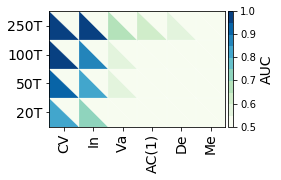

In [32]:

M = 6
N = 4
x = np.arange(M + 1)
y = np.arange(N + 1)
xs, ys = np.meshgrid(x, y)
sort_values_auc = sort_by_combinedAUC
z_steadystate = abs(area_under_curve_df[sort_values_auc]).values
z_steadystate = z_steadystate.ravel()

z_changing = abs(area_under_curve_dfCHANGE[sort_values_auc]).values
z_changing  = z_changing.ravel()

plt.figure(figsize = (4,2.6))
triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]

triang1 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles1)
triang2 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles2)
img1 = plt.tripcolor(triang1, z_steadystate, cmap=plt.get_cmap('GnBu',10), vmax=1, vmin = 0.5)
img2 = plt.tripcolor(triang2, z_changing,linewidth=0.2,edgecolor = 'white',
                     cmap=plt.get_cmap('GnBu', 10), vmax=1, vmin =0.5)

cbar = plt.colorbar(img1, ticks=np.arange(0.5,1.1,0.1), pad = 0.01,label ='AUC')
plt.xlim(x[0]-0.5, x[-1]-0.5)
plt.ylim(y[0]-0.5, y[-1]-0.5)
plt.xticks(x[:-1], sort_values_auc, rotation=90, fontsize = 14)
plt.yticks(y[:-1], area_under_curve_dfCHANGE.index.values, rotation=0, fontsize = 14)
cbar.ax.set_ylabel('AUC', size=14)

plt.tight_layout()
plt.savefig('Figs/auc_compare_changing_steady_pvalue.pdf',bbox_inches='tight')

# Figure S3 - Number of consecutive points
Plotted in `AUC_best_consecutive.ipynb`

In [33]:
best_threshold_choiceCHANGE = pd.DataFrame(data = threshold_results_CHANGE, columns=false_positive_rate_100.index,
             index = [  '20T', '50T','100T', '250T'])

In [34]:
best_threshold = best_threshold_choiceCHANGE.T.melt()
best_threshold['null'] = 'NExt'
best_threshold['length'] = [int(x.split('T')[0]) for x in best_threshold.variable]
best_threshold['Best number consecutive (% of time series length)'] =( best_threshold['value']/best_threshold['length'])*100
best_threshold['threshold']= best_threshold['value']

best_threshold2 = best_threshold_choice.T.melt()
best_threshold2['null'] = 'Fix'
best_threshold2['length'] = [int(x.split('T')[0]) for x in best_threshold2.variable]
best_threshold2['Best number consecutive (% of time series length)'] = (best_threshold2['value']/best_threshold2['length'])*100
best_threshold2['threshold']= best_threshold2['value']

best_threshold_both = pd.concat([best_threshold, best_threshold2])


In [35]:
best_threshold_both = pd.concat([best_threshold, best_threshold2])


In [36]:
best_auc = area_under_curve_dfCHANGE.T.melt()
best_auc['null'] = 'NExt'
best_auc['length'] = [int(x.split('T')[0]) for x in best_auc.variable]
best_auc['AUC'] = best_auc['value']

best_auc2 = area_under_curve_df.T.melt()
best_auc2['null'] = 'Fix'
best_auc2['length'] = [int(x.split('T')[0]) for x in best_auc2.variable]
best_auc2['AUC'] = best_auc2['value']

best_auc_both = pd.concat([best_auc, best_auc2])


In [37]:
both_results = pd.concat([best_auc_both, best_threshold_both],axis=1)
both_results =both_results.loc[:,~both_results.columns.duplicated()]

In [38]:
both_results.to_csv('Figs/kendall_results.csv')

# Figure 9- Time-of-detection from simulated data

In [39]:
best_number_consec = [5]
stats_of_interest = ['CV']

In [40]:
Time =100
realisations = 500
Ext_res, Fix_res, FixChange_res = open_pvalue_files(Time)

ext_return = loop_EWSs_store_results_pvalue(dict_input=Ext_res, 
                                          consecutive_length=best_number_consec,
                                          all_stats=stats_of_interest,
                                          realisations=realisations,
                                       time_range=np.arange(Time//5,
                                                            Time, 1))

fix_return = loop_EWSs_store_results_pvalue(dict_input=Fix_res, 
                                          consecutive_length=best_number_consec,
                                          all_stats=stats_of_interest,
                                          realisations=realisations,
                                       time_range=np.arange(Time//5,
                                                            Time, 1))

fixCHANGE_return = loop_EWSs_store_results_pvalue(dict_input=FixChange_res, 
                                          consecutive_length=best_number_consec,
                                          all_stats=stats_of_interest,
                                          realisations=realisations,
                                       time_range=np.arange(Time//5,
                                                            Time, 1))

In [41]:
ext_dates  = pd.concat(ext_return['start'], axis =0)
ext_dates = ext_dates.reset_index()
fix_dates  = pd.concat(fix_return['start'], axis =0)
fix_dates = fix_dates.reset_index()
fixCHANGE_dates  = pd.concat(fixCHANGE_return['start'], axis =0)
fixCHANGE_dates = fixCHANGE_dates.reset_index()

In [42]:
select_values = ['CV']

In [43]:
colnames = ([z+'_true positives' for z in select_values]+
            [z+'_false positives 1' for z in select_values]+
           [z+'_false positives 2' for z in select_values])

In [44]:
ext_fix = ext_dates.merge(fix_dates, on ='level_0', suffixes=('_true positives', '_false positives 1'))
both = ext_fix.merge(fixCHANGE_dates.add_suffix('_false positives 2'), left_on='level_0', right_on = 'level_0_false positives 2')
plot_df = pd.melt(both[colnames])
plot_df['datatype']=[z.split('_')[-1] for z in plot_df.variable.values]
plot_df['statistic']=[z.split('_')[0] for z in plot_df.variable.values]

In [45]:
plot_df['value'] = plot_df['value'] + best_number_consec[0]

In [46]:
my_pal = {"true positives": "#a6cee3", "false positives 1":"#b2df8a" , "false positives 2":"#8c6bb1"}


/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 19.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 16.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


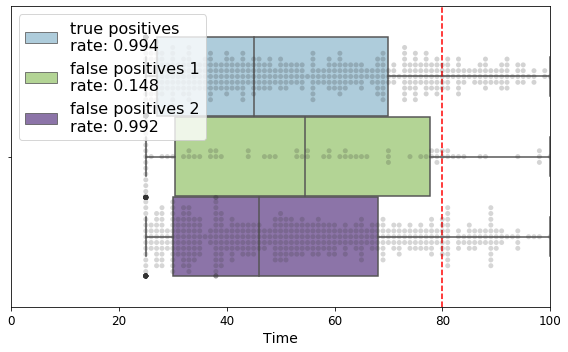

In [47]:
fig, ax = plt.subplots(1, figsize = (8,5))
stat = 'CV'
DF = plot_df[plot_df.variable.isin([stat + x for x in ['_true positives',
                                                             '_false positives 1',
                                                             '_false positives 2']])]

sns.boxplot(x="value", y="statistic",hue='datatype', data = DF, whis=np.inf, palette=my_pal,
           ax = ax)

axes = sns.swarmplot(x='value', y='statistic',hue='datatype', data = DF,
                   dodge = True,color=".2",alpha=0.2,label='', ax = ax)
ax.axvline(80, color = 'r', linestyle='--', label = r'$R_0=1$')  
handles, labels = axes.get_legend_handles_labels()
axes.set(xlabel='Time')
axes.set(ylabel = None)
axes.tick_params(labelleft=False)    
tpr = DF[(DF.datatype=='true positives') & (~DF['value'].isnull())].shape[0]/500
fpr1 =DF[(DF.datatype=='false positives 1') & (~DF['value'].isnull())].shape[0]/500
fpr2 = DF[(DF.datatype=='false positives 2') & (~DF['value'].isnull())].shape[0]/500
labels_rate = [l + '\nrate: ' + str(r) for l, r in zip(labels[1:-1], [tpr, fpr1, fpr2])]
axes.legend(handles[1:-1], labels_rate, loc = 'upper left', fontsize = 16)
ax.set_xlabel('Time', fontsize =14)
ax.xaxis.set_tick_params(labelsize=12)
axes.set_xlim([0,100])
fig.tight_layout()
fig.savefig('Figs/CV_pvalue_dist.pdf')